In [37]:
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

from typing import Dict, List
import random
from collections import defaultdict

import choix

from scipy.stats import spearmanr

from api.util import load_json

import pandas as pd
from factor_analyzer import FactorAnalyzer
from sklearn.preprocessing import MinMaxScaler

players = ["random", "gpt3", "gpt3-cot", "gpt4", "gpt4-cot", "rap"]
players.sort()

## correlation matrix


In [38]:
def rank_centrality(n_items, data, alpha=0.0):
    # https://choix.lum.li/en/latest/_modules/choix/lsr.html#rank_centrality
    _, chain = choix.lsr._init_lsr(n_items, alpha, None)
    for p1, p2, p1score, p2score in data:
        chain[p2, p1] += float(p1score)
    idx = chain > 0
    chain[idx] = chain[idx] / (chain + chain.T)[idx]
    chain -= np.diag(chain.sum(axis=-1))
    return choix.utils.log_transform(choix.utils.statdist(chain))


def get_skill_ratings(game: str) -> List[float]:
    """Given the name of a game, return an unlabeled list of skill ratings representing how skilled each model is at that game."""

    filtered_matches = [
        m
        for m in load_json("matches.json")
        if "gpt3-bap" not in m and "gpt4-bap" not in m and m["game"] == game
    ]

    def get_params(matches):
        wins = []
        for match in matches:
            agents = list(match.keys())[1:]
            if match[agents[0]] == match[agents[1]]:
                continue

            i = players.index(agents[0])
            j = players.index(agents[1])

            wins.append((i, j, match[agents[0]], match[agents[1]]))

        params = rank_centrality(len(players), wins, alpha=0.001)
        return params

    bootstrapped_params = np.array(
        [
            get_params(random.choices(filtered_matches, k=len(filtered_matches)))
            for _ in range(100)
        ]
    ).transpose((1, 0))
    ratings = bootstrapped_params.mean(1)
    return list(ratings)

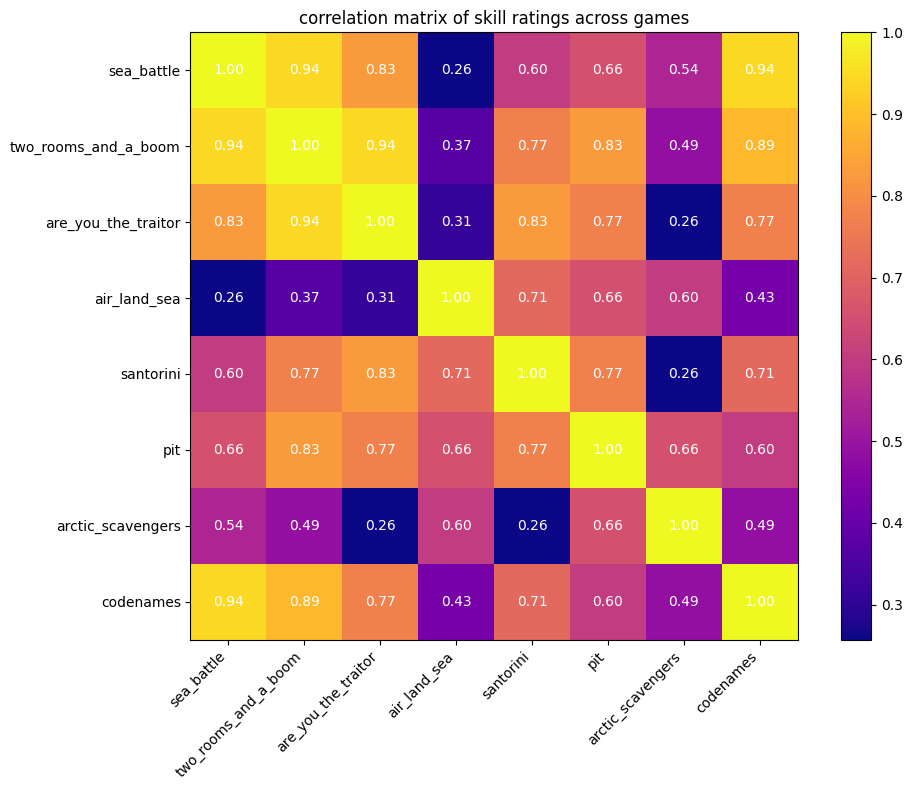

In [39]:
def show_correlation_matrix(ratings: Dict[str, List[float]]):
    games = list(ratings.keys())

    # Calculate the correlation matrix
    corr_matrix = np.zeros((len(games), len(games)))
    for i, game1 in enumerate(games):
        for j, game2 in enumerate(games):
            corr, _ = spearmanr(ratings[game1], ratings[game2])
            corr_matrix[i, j] = corr

    # Visualize the correlation matrix using matplotlib
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(corr_matrix, cmap="plasma")

    # Set ticks and labels
    ax.set_xticks(np.arange(len(games)))
    ax.set_yticks(np.arange(len(games)))
    ax.set_xticklabels(games, rotation=45, ha="right")
    ax.set_yticklabels(games)

    # Loop over data dimensions and create text annotations
    for i in range(len(games)):
        for j in range(len(games)):
            ax.text(
                j, i, f"{corr_matrix[i, j]:.2f}", ha="center", va="center", color="w"
            )

    ax.set_title("correlation matrix of skill ratings across games")

    fig.tight_layout()
    plt.colorbar(im, ax=ax)
    plt.show()


game_names = [
    "sea_battle",
    "two_rooms_and_a_boom",
    "are_you_the_traitor",
    "air_land_sea",
    "santorini",
    # "hive",
    "pit",
    "arctic_scavengers",
    "codenames",
    # "atari_boxing",
]

skill_ratings: Dict[str, List[float]] = {
    game: get_skill_ratings(game) for game in game_names
}

show_correlation_matrix(skill_ratings)

## factor analysis


In [42]:
fa = FactorAnalyzer(n_factors=1, rotation=None)

df_skill_ratings = pd.DataFrame(skill_ratings, index=players)
fa.fit(df_skill_ratings)

fa.loadings_

array([[-0.61049119],
       [-1.00115111],
       [-0.97810091],
       [-0.97781077],
       [-0.98259078],
       [-0.9781731 ],
       [-0.95542561],
       [-0.98781255]])

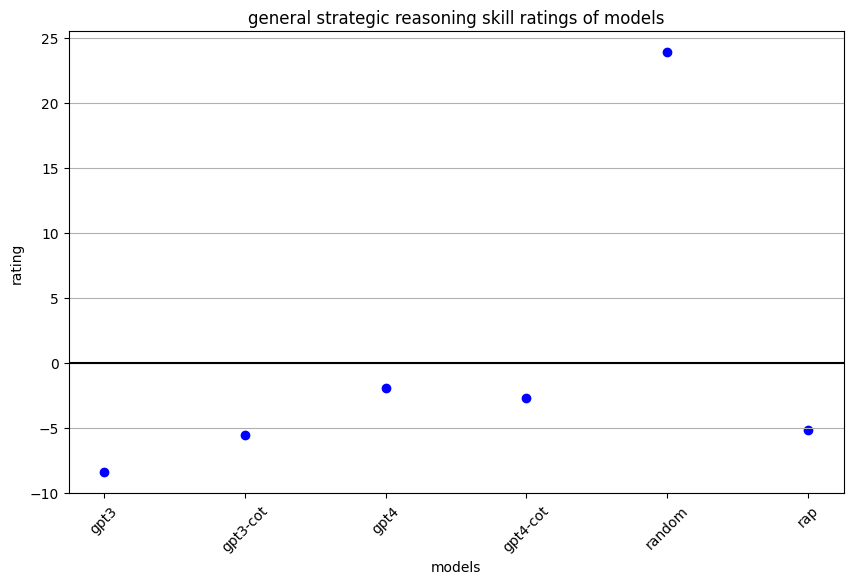

In [44]:
# Calculate the general ratings
general_ratings = df_skill_ratings.dot(fa.loadings_).squeeze()

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(players, general_ratings, color="blue")

plt.xticks(
    range(len(players)), players, rotation=45
)  # Ensure player names are on x-axis
plt.grid(True, axis="y")
plt.axhline(0, color="black", linewidth=1.5)  # Emphasize the x-axis line at y = 0

plt.xlabel("models")
plt.ylabel("rating")
plt.title("general strategic reasoning skill ratings of models")

plt.show()